# IHLT Lab 5: Lexical Semantics

**Authors:** *Zachary Parent ([zachary.parent](mailto:zachary.parent@estudiantat.upc.edu)), Carlos Jiménez ([carlos.humberto.jimenez](mailto:carlos.humberto.jimenez@estudiantat.upc.edu))*

### 2024-10-17

**Instructions:**

- Given the following (lemma, category) pairs:

`(’the’,’DT’), (’man’,’NN’), (’swim’,’VB’), (’with’, ’PR’), (’a’, ’DT’),
(’girl’,’NN’), (’and’, ’CC’), (’a’, ’DT’), (’boy’, ’NN’), (’whilst’, ’PR’),
(’the’, ’DT’), (’woman’, ’NN’), (’walk’, ’VB’)`

- For each pair, when possible, print their most frequent WordNet synset

- For each pair of words, when possible, print their corresponding least common subsumer (LCS) and their similarity value, using the following functions:

    - Path Similarity

    - Peacock-Chodorow Similarity

    - Wu-Palmer Similarity

    - Lin Similarity

Normalize similarity values when necessary. What similarity seems better?

## Notes

- we should normalize the lch_similarity (not all trees have the same depth)
- most frequent ~= most likely
- lemmas have an attribute 'count'
- given synsets we can get lemmas and counts
- we should established rules/criteria to identify which similarity is 'best'
- not all the words have an entry in wordnet, in that case computing the similarity is not possible
  - we should compute our own sorting method by lemmas count


## Setup

In [150]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
from nltk.corpus import sentiwordnet as swn
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
import itertools

In [91]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('sentiwordnet')
nltk.download('wordnet_ic')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/carlos.jimenez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/carlos.jimenez/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /home/carlos.jimenez/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet_ic to
[nltk_data]     /home/carlos.jimenez/nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!


True

## LCH Normalization

In [92]:
def get_max_depth(pos: str):
    return max(synset.max_depth() for synset in wn.all_synsets(pos))

max_lch = {
    'n': math.log(2 * get_max_depth('n')),
    'v': math.log(2 * get_max_depth('v'))
}

def normalized_lch_similarity(synset1, synset2, pos: str):
    lch_sim = wn.lch_similarity(synset1, synset2)
    return lch_sim / max_lch[pos]  # Sigmoid function


## WordNet Similarities

In [93]:
words = [('the','DT'), ('man','NN'), ('swim','VB'), ('with', 'PR'), ('a', 'DT'),
('girl','NN'), ('and', 'CC'), ('a', 'DT'), ('boy', 'NN'), ('whilst', 'PR'),
('the', 'DT'), ('woman', 'NN'), ('walk', 'VB')]

In [94]:
synset_pos_converter = {
    'NN': 'n',
    'VB': 'v',
}

In [151]:
def get_most_frequent_synset(word, pos):
    max_count = 0
    most_frequent_synset = None 

    for synset in wn.synsets(word, pos):
        for lemma in synset.lemmas():
            if lemma.name() == word and lemma.count() > max_count:
                max_count = lemma.count()
                most_frequent_synset = synset.name()
                    
    return most_frequent_synset

## Getting Least Common Subsumer (LCS) for each pair of words (when possible)

In [169]:
def get_lcs(word1, word2):
    try:
        w1, p1 = word1
        w2, p2 = word2

        s1 = get_most_frequent_synset(w1, p1)
        s2 = get_most_frequent_synset(w2, p2)
        
        s1 = wn.synset(s1)
        s2 = wn.synset(s2)

        if s1 and s2:
            lcs = s1.lowest_common_hypernyms(s2)
            if lcs:
                print(f"LCS for '{w1}' and '{w2}': {lcs[0].name()}")
        else:
            print(f"No synsets found for '{s1}' or '{s2}'")
            
    except Exception as e:
        print(f"Error finding LCS: {e}")

In [170]:
for i in range(len(words)):
    for j in range(i + 1, len(words)):
        word1, pos1 = words[i]
        word2, pos2 = words[j]
        
        pos1 = synset_pos_converter.get(pos1)
        pos2 = synset_pos_converter.get(pos2)
        

        # Only compare words with noun (NN) or verb (VB) POS tags
        if pos1 and pos2:
    #         print(word1, word2)
            get_lcs((word1,pos1), (word2, pos2))

LCS for 'man' and 'girl': adult.n.01
LCS for 'man' and 'boy': male.n.02
LCS for 'man' and 'woman': adult.n.01
LCS for 'swim' and 'walk': travel.v.01
LCS for 'girl' and 'boy': person.n.01
LCS for 'girl' and 'woman': woman.n.01
LCS for 'boy' and 'woman': person.n.01


In [96]:
words_df = pd.DataFrame(words,columns=['word', 'pos'])
words_df['synset_pos'] = words_df['pos'].apply(lambda pos: synset_pos_converter[pos] if pos in synset_pos_converter else None)
words_df.sort_values(by='synset_pos', inplace=True)
words_df.reset_index(drop=True, inplace=True)

print(f"Null values:\n{words_df.isnull().sum()}")
words_df.dropna(inplace=True)
print(f"Null values:\n{words_df.isnull().sum()}")

words_df['synset_accessor'] = words_df.apply(lambda row: get_most_frequent_synset(row['word'], row['synset_pos']), axis=1)
words_df

Null values:
word          0
pos           0
synset_pos    7
dtype: int64
Null values:
word          0
pos           0
synset_pos    0
dtype: int64


,word,pos,synset_pos,synset_accessor
0,man,NN,n,man.n.01
1,girl,NN,n,girl.n.01
2,boy,NN,n,male_child.n.01
3,woman,NN,n,woman.n.01
4,swim,VB,v,swim.v.01
5,walk,VB,v,walk.v.01


# Computing Similarities

In [97]:
def get_similarity_matrix(words_df: pd.DataFrame, similarity_fn: callable) -> pd.DataFrame:
    similarity_matrix = pd.DataFrame(columns=words_df['word'], index=words_df['word'])
    for _, (word1, _, _, word1_synset_accessor) in words_df.iterrows():
        word1_synset = wn.synset(word1_synset_accessor)
        for _, (word2, _, _, word2_synset_accessor) in words_df.iterrows():
            word2_synset = wn.synset(word2_synset_accessor)
            similarity_matrix.loc[word1, word2] = similarity_fn(word1_synset, word2_synset)
    return similarity_matrix

## Path Similarity
- Calculates the shortest path distance between two synsets in the WordNet hierarchy.
- Lower values indicate higher similarity.
- It's simple to compute but can be misleading for concepts with multiple inheritance paths.

In [98]:
verb_words = words_df[words_df['synset_pos'] == 'v']['word'].tolist()
noun_words = words_df[words_df['synset_pos'] == 'n']['word'].tolist()

In [99]:
# path_similarities = get_similarity_matrix(words_df, wn.path_similarity)
path_similarities = pd.DataFrame(index=words_df['word'].to_list(), columns=words_df['word'])
path_similarities.loc[verb_words, verb_words] = get_similarity_matrix(words_df[words_df['synset_pos'] == 'v'], wn.path_similarity)
path_similarities.loc[noun_words, noun_words] = get_similarity_matrix(words_df[words_df['synset_pos'] == 'n'], wn.path_similarity)
path_similarities = path_similarities.astype(float).fillna(0)

path_similarities

word,man,girl,boy,woman,swim,walk
man,1.000000,0.250000,0.333333,0.333333,0.000000,0.000000
girl,0.250000,1.000000,0.166667,0.500000,0.000000,0.000000
boy,0.333333,0.166667,1.000000,0.200000,0.000000,0.000000
woman,0.333333,0.500000,0.200000,1.000000,0.000000,0.000000
swim,0.000000,0.000000,0.000000,0.000000,1.000000,0.333333
walk,0.000000,0.000000,0.000000,0.000000,0.333333,1.000000


## Leacock-Chodorow Similarity

- Considers the depth of the least common subsumer (LCS) and the path length to it.
- Higher values indicate higher similarity.
- It incorporates depth information but is sensitive to the overall depth of the taxonomy.

In [100]:
lch_similarities = pd.DataFrame(index=words_df['word'].to_list(), columns=words_df['word'])
lch_similarities.loc[verb_words, verb_words] = get_similarity_matrix(words_df[words_df['synset_pos'] == 'v'], partial(normalized_lch_similarity, pos='v'))
lch_similarities.loc[noun_words, noun_words] = get_similarity_matrix(words_df[words_df['synset_pos'] == 'n'], partial(normalized_lch_similarity, pos='n'))
lch_similarities = lch_similarities.astype(float).fillna(0)

lch_similarities

word,man,girl,boy,woman,swim,walk
man,1.000000,0.618897,0.697983,0.697983,0.000000,0.000000
girl,0.618897,1.000000,0.507432,0.809449,0.000000,0.000000
boy,0.697983,0.507432,1.000000,0.557553,0.000000,0.000000
woman,0.697983,0.809449,0.557553,1.000000,0.000000,0.000000
swim,0.000000,0.000000,0.000000,0.000000,1.025186,0.679499
walk,0.000000,0.000000,0.000000,0.000000,0.679499,1.025186


## Wu-Palmer Similarity

- Calculates similarity based on the depth of the LCS and the depths of the two synsets.
- Higher values indicate higher similarity.
- It's more robust than Path similarity and less sensitive to taxonomy depth than LCH.

In [101]:
wup_similarities = pd.DataFrame(index=words_df['word'].to_list(), columns=words_df['word'])
wup_similarities.loc[:] = get_similarity_matrix(words_df, wn.wup_similarity)
wup_similarities = wup_similarities.astype(float)

wup_similarities

word,man,girl,boy,woman,swim,walk
man,1.000000,0.631579,0.666667,0.666667,0.181818,0.181818
girl,0.631579,1.000000,0.631579,0.631579,0.166667,0.166667
boy,0.666667,0.631579,1.000000,0.666667,0.181818,0.181818
woman,0.666667,0.947368,0.666667,1.000000,0.181818,0.181818
swim,0.181818,0.166667,0.181818,0.181818,1.000000,0.333333
walk,0.181818,0.166667,0.181818,0.181818,0.333333,1.000000


## Lin Similarity

- Uses the Information Content (IC) of the LCS and the two synsets. 
- Higher values indicate higher similarity.
- It incorporates information content, reflecting the specificity of concepts, but requires pre-computed IC values.

In [113]:
brown_ic = wordnet_ic.ic('ic-brown.dat') # information content

lin_similarities = pd.DataFrame(index=words_df['word'].to_list(), columns=words_df['word'])
lin_similarities.loc[verb_words, verb_words] = get_similarity_matrix(words_df[words_df['synset_pos'] == 'v'], partial(wn.lin_similarity, ic=brown_ic))
lin_similarities.loc[noun_words, noun_words] = get_similarity_matrix(words_df[words_df['synset_pos'] == 'n'], partial(wn.lin_similarity, ic=brown_ic))
lin_similarities = lin_similarities.astype(float).fillna(0)

lin_similarities

word,man,girl,boy,woman,swim,walk
man,1.000000,0.713511,0.729472,0.787084,0.000000,0.000000
girl,0.713511,1.000000,0.292728,0.906780,0.000000,0.000000
boy,0.729472,0.292728,1.000000,0.318423,0.000000,0.000000
woman,0.787084,0.906780,0.318423,1.000000,0.000000,0.000000
swim,0.000000,0.000000,0.000000,0.000000,1.000000,0.491005
walk,0.000000,0.000000,0.000000,0.000000,0.491005,1.000000


# Visualizations

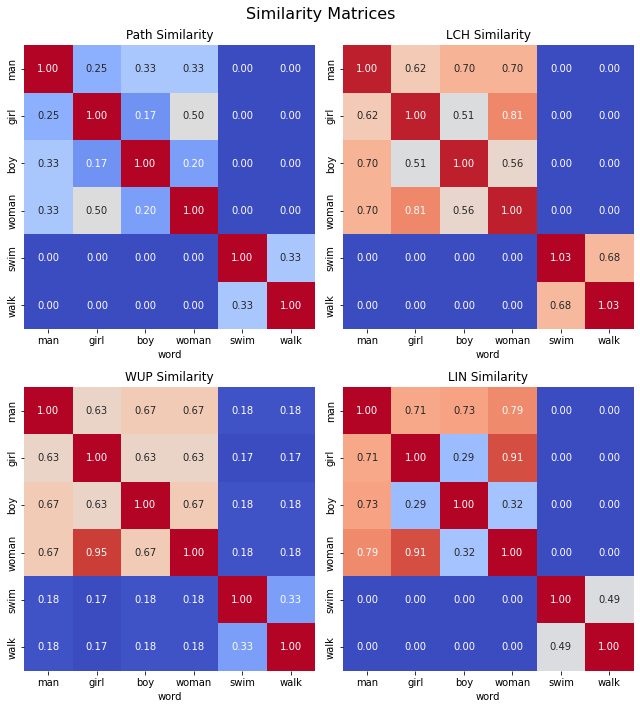

In [103]:
def plot_similarity_matrix(ax, similarity_matrix: pd.DataFrame, title: str):
    sns.heatmap(similarity_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=ax, cbar=False)
    ax.set_title(title)

fig, axs = plt.subplots(2, 2, figsize=(9, 10))

plot_similarity_matrix(axs[0, 0], path_similarities, 'Path Similarity')
plot_similarity_matrix(axs[0, 1], lch_similarities, 'LCH Similarity')
plot_similarity_matrix(axs[1, 0], wup_similarities, 'WUP Similarity')
plot_similarity_matrix(axs[1, 1], lin_similarities, 'LIN Similarity')

fig.suptitle('Similarity Matrices', fontsize=16)
plt.tight_layout()
plt.show()


## Investigating the discrepency in Wu-Palmer Similarity between girl and woman

### We noticed that the Wu-Palmer Similarity between woman and girl is ~0.95, while the similarity between girl and woman is 0.63.

### To understand this issue, we decided to calculate the similarity manually.

In [104]:
print(f"similarity between woman and girl: {wn.wup_similarity(wn.synset('woman.n.01'), wn.synset('girl.n.01'))}")
print (f"similarity between girl and woman: {wn.wup_similarity(wn.synset('girl.n.01'), wn.synset('woman.n.01'))}")

similarity between woman and girl: 0.9473684210526315
similarity between girl and woman: 0.631578947368421


In [105]:
woman = wn.synset('woman.n.01')
girl = wn.synset('girl.n.01')
lcs = woman.lowest_common_hypernyms(girl)[0]

similarity = 2 * lcs.max_depth() / (woman.max_depth() + girl.max_depth())
print(f"Manually calculated similarity between woman and girl: {similarity}")

Manually calculated similarity between woman and girl: 0.9411764705882353


In [106]:
woman = wn.synset('woman.n.01')
girl = wn.synset('girl.n.01')
lcs = girl.lowest_common_hypernyms(woman)[0]

similarity = 2 * lcs.max_depth() / (woman.max_depth() + girl.max_depth())
print(f"Manually calculated similarity between girl and woman: {similarity}")

Manually calculated similarity between girl and woman: 0.9411764705882353


As expected, the similarity between girl and woman is the same as the similarity between woman and girl. Perhaps the cached similarity in the wn.wup_similarity function is incorrect.

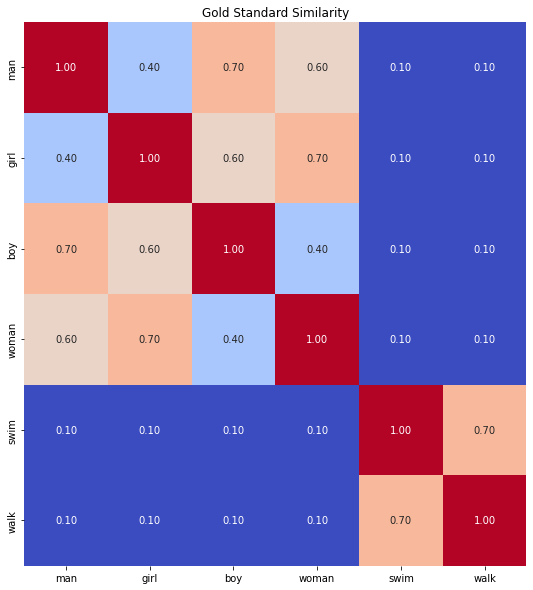

In [107]:
gold_standard_similarity = pd.DataFrame(
    columns=['man', 'girl', 'boy', 'woman', 'swim', 'walk'],
    index=['man', 'girl', 'boy', 'woman', 'swim', 'walk'],
    data={
        'man': [1.0, 0.4, 0.7, 0.6, 0.1, 0.1],
        'girl': [0.4, 1.0, 0.6, 0.7, 0.1, 0.1],
        'boy': [0.7, 0.6, 1.0, 0.4, 0.1, 0.1],
        'woman': [0.6, 0.7, 0.4, 1.0, 0.1, 0.1],
        'swim': [0.1, 0.1, 0.1, 0.1, 1.0, 0.7],
        'walk': [0.1, 0.1, 0.1, 0.1, 0.7, 1.0]
})
fig, ax = plt.subplots(1, 1, figsize=(9, 10))
plot_similarity_matrix(ax, gold_standard_similarity, 'Gold Standard Similarity')
plt.show()


In [112]:
from scipy.stats import pearsonr

similarity_scores = {
    'Path': pearsonr(path_similarities.values.flatten(), gold_standard_similarity.values.flatten())[0],
    'LCH': pearsonr(lch_similarities.values.flatten(), gold_standard_similarity.values.flatten())[0],
    'WUP': pearsonr(wup_similarities.values.flatten(), gold_standard_similarity.values.flatten())[0],
    'Lin': pearsonr(lin_similarities.values.flatten(), gold_standard_similarity.values.flatten())[0]
}

# print(similarity_scores)
# similarity_scores = pd.DataFrame(np.array(similarity_scores).T, columns=['Score'])


similarity_scores = pd.DataFrame(list(similarity_scores.items()), columns=['Function', 'Score'])


print("Similarity scores (Pearson correlation with gold standard):")
similarity_scores

Similarity scores (Pearson correlation with gold standard):


,Function,Score
0,Path,0.936580
1,LCH,0.975836
2,WUP,0.926219
3,Lin,0.940212


# Conclusions

- ### What similarity seems better?



### In this lab we evaluated different similarity functions for synsets, our analysis of various lexical similarity measures reveals that ***Wu-Palmer*** and ***Lin similarity*** exhibit a stronger correlation with human intuition regarding semantic relatedness compared to Path and Leacock-Chodorow similarity. 

### This is evidenced by their higher Pearson correlation with the gold standard and superior performance in capturing the nuanced relationships between word pairs such as ("man", "woman") and ("swim", "walk"). However, it is crucial to acknowledge that the effectiveness of a similarity measure can be context-dependent.  

### Further investigation involving correlation with human judgments and evaluation on specific NLP tasks, such as word sense disambiguation or text classification, is necessary to definitively determine the most suitable measure for a given application.  While Wu-Palmer and Lin similarity appear promising based on our initial analysis, future research should explore their limitations and potential areas for improvement, particularly in addressing complex linguistic phenomena like metaphor and polysemy.
